# 도메인과 통념 반영 + 중복 관측치에 대한 아이디어

# 1. 중복 데이터 확인 및 처리 방법 생각

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
## 데이터 불러오기
trn = pd.read_csv('data/train.csv')
tst = pd.read_csv('data/test.csv')

In [4]:
trn.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [5]:
## identity 변수
trn['ident']=''
for i in range(trn.shape[1]-4):
    trn['ident']=trn['ident']+trn.drop(['index','begin_month','credit', 'income_total'],axis=1).iloc[:,i].astype(str)


trn=pd.merge(trn,trn.groupby('ident').index.count(),how='left',on='ident')
trn.rename(columns = {'index_y' : 'num_card',
                     'index_x' : 'index'}, inplace = True)
trn.set_index('index', inplace = True)


## 나이 변환
def days_to_age(x):
    return (x*-1)/365

## 신용카드 발급월 양수로 전환
def begin_plus_month(x):
    return (x*-1)

## 신용카드 발급월 연도로 전환
def begin_plus_year(x):
    return (x)//12

## 업무 시작일 변환
def plus(x):
    if x<0:
        return x*(-1)
    else:
        return 0


## 나이로 변환
trn['birth'] = days_to_age(trn.DAYS_BIRTH).round()

## 나이 구간화
trn['age']=(trn.DAYS_BIRTH*(-1)/365).apply(lambda x:str(x)[0]+'0')
trn.drop('DAYS_BIRTH', axis=1, inplace = True)

## 신용카드 발급월 변수의 변환
trn['begin_month_plus'] = begin_plus_month(trn.begin_month).round()
trn.drop('begin_month', axis=1, inplace = True)

## 신용카드 발급월 연차로 변환
trn['begin_month_year'] = begin_plus_year(trn.begin_month_plus)

# ## 신용카드 발급월 구간화
# trn['begin_month_bin'] = (trn.begin_month_plus*10).apply(lambda x:str(x)[0]+'0')

## 업무시작일 양수로 변환
trn['employed_plus'] = trn.DAYS_EMPLOYED.map(plus)

## 0과 1로 범주화 (업무를 하는 사람과 아닌 사람)
trn['employed_bin'] = trn.employed_plus.map(lambda x : 0 if x==0 else 1)

## 업무 연차로 변환
trn['employed_bin2'] = trn['employed_plus']//365

In [246]:
## identity 변수
tst['ident']=''
for i in range(tst.shape[1]-4):
    tst['ident']=tst['ident']+tst.drop(['index','begin_month', 'income_total'],axis=1).iloc[:,i].astype(str)


tst=pd.merge(tst,tst.groupby('ident').index.count(),how='left',on='ident')
tst.rename(columns = {'index_y' : 'num_card',
                     'index_x' : 'index'}, inplace = True)
tst.set_index('index', inplace = True)

## 나이로 변환
tst['birth'] = days_to_age(tst.DAYS_BIRTH).round()

## 나이 구간화
tst['age']=(tst.DAYS_BIRTH*(-1)/365).apply(lambda x:str(x)[0]+'0')
tst.drop('DAYS_BIRTH', axis=1, inplace = True)

## 신용카드 발급월 변수의 변환
tst['begin_month_plus'] = begin_plus_month(tst.begin_month).round()
tst.drop('begin_month', axis=1, inplace = True)

## 신용카드 발급월 연차로 변환
tst['begin_month_year'] = begin_plus_year(tst.begin_month_plus)

# ## 신용카드 발급월 구간화
# tst['begin_month_bin'] = (tst.begin_month_plus*10).apply(lambda x:str(x)[0]+'0')

## 업무시작일 양수로 변환
tst['employed_plus'] = tst.DAYS_EMPLOYED.map(plus)

## 0과 1로 범주화 (업무를 하는 사람과 아닌 사람)
tst['employed_bin'] = tst.employed_plus.map(lambda x : 0 if x==0 else 1)

## 업무 연차로 변환
tst['employed_bin2'] = tst['employed_plus']//365

In [67]:
# trn=trn.drop(['ident','index_y'],axis=1)
# trn[['ident', 'num_card','begin_month']].sort_values(by = 'begin_month')

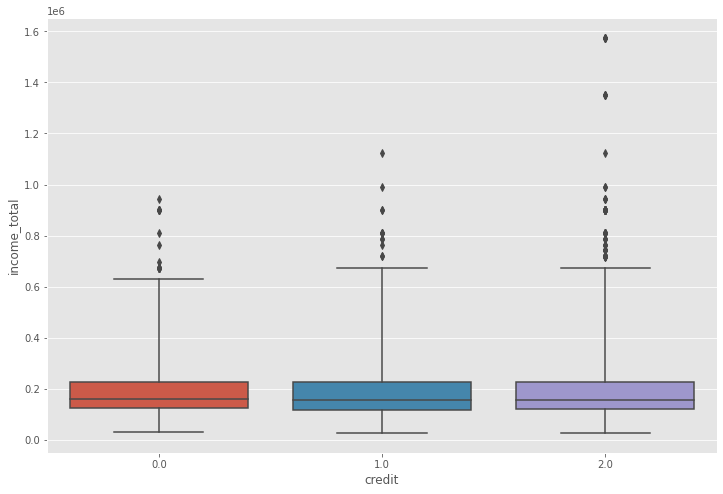

In [72]:
plt.figure(figsize = (12, 8))
sns.boxplot(x = "credit", y = "income_total", whis = 4.5, data = trn)
# sns.swarmplot(x = "credit", y = "income_total", data = trn, color = '0.25')
plt.show()

In [73]:
## 최댓값의 credit
trn[trn.income_total == trn.income_total.max()]['credit']

index
1656     2.0
10564    2.0
14702    2.0
15903    2.0
18445    2.0
Name: credit, dtype: float64

In [74]:
## 최솟값의 credit
trn[trn.income_total == trn.income_total.min()]['credit']

index
6693     2.0
11224    1.0
Name: credit, dtype: float64

In [75]:
print(trn[trn.income_total == trn.income_total.max()]["ident"].reset_index(drop = True)[0])
print()
print(print(trn[trn.income_total == trn.income_total.max()]["ident"].reset_index(drop = True)[1]))

FYY1Commercial associateHigher educationSingle / not marriedHouse / apartment-10142-24791000Managers2.0FYY1Commercial associateHigher educationSingle / not marriedHouse / apartment-10142-24791000Managers2.0

FYY1Commercial associateHigher educationSingle / not marriedHouse / apartment-10142-24791000Managers2.0FYY1Commercial associateHigher educationSingle / not marriedHouse / apartment-10142-24791000Managers2.0
None


In [77]:
trn.duplicated(['ident'], keep = 'first').value_counts()

True     17709
False     8748
dtype: int64

In [53]:
trn[trn.income_total == trn.income_total.min()]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,birth,age,begin_month_plus,begin_month_year,begin_month_bin,employed_plus,employed_bin,employed_bin2,ident,num_card
index,,,,,,,,,,,,,,,,,,,,,
6693,F,N,N,0,27000.0,Working,Higher education,Civil marriage,House / apartment,-5067,...,41.0,40,31.0,2.0,30,5067,1,13,FNN0WorkingHigher educationCivil marriageHouse...,1
11224,F,N,Y,0,27000.0,Working,Secondary / secondary special,Married,House / apartment,-1323,...,52.0,50,28.0,2.0,20,1323,1,3,FNY0WorkingSecondary / secondary specialMarrie...,1


trn['num'] = 1
trn[['begin_month_bin', 'credit', 'num_card', 'num']].groupby(['begin_month_bin','credit'])['num_card'].count()

<AxesSubplot:xlabel='num_card'>

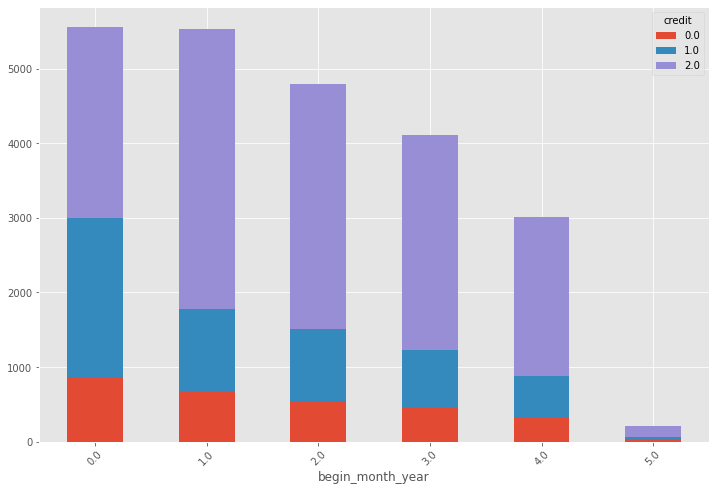

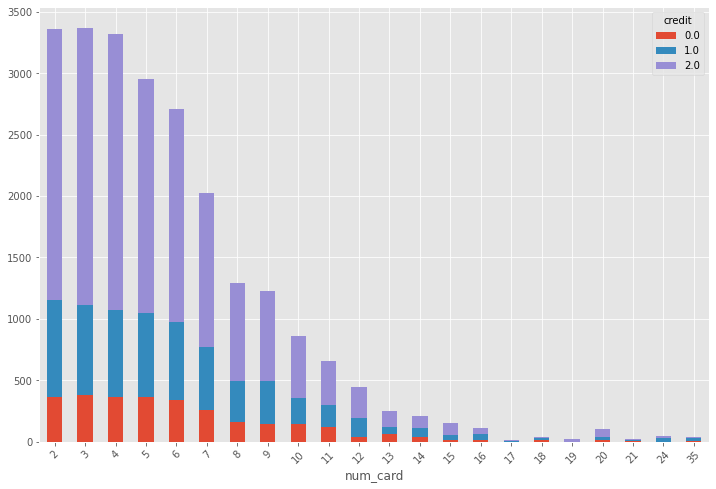

In [78]:
dum_trn = trn[trn['num_card']>=2].copy()

tab = pd.crosstab(index = dum_trn['begin_month_year'], columns = dum_trn.credit)
tab.plot(kind='bar', stacked=True, figsize = (12,8), rot=45)


## 카드 개수
tab = pd.crosstab(index = dum_trn['num_card'], columns = dum_trn.credit)
tab.plot(kind='bar', stacked=True, figsize = (12,8), rot=45)

- 기간과 카드 수 모두 credit이 골고루 섞여 있음
- 동일 인물이면 기간에 따라서 숫자를 다르게 부여해보자
- ex) 처음 만든 시점 = 1, 두 번째로 만든 시점 = 2,..
- 이 척도를 중복이 있는 모두에게 적용. 중복이 없는 사람은 0으로 그냥 둠




- 공통되는 사람별로 시점의 차이가 얼마나 있는지 확인하자.
- 변수들 간의 상관관계를 보고 최대한 줄여보자

- 기존의 관측치 만으로 중복데이터를 확인
- 중복 관측치를 확인할 때 연봉을 제외함
- 나중에 신용도가 떨어진 경우 (동일인 가정) 연봉은 변할 수 있다고 생각

In [127]:
df = trn[trn['num_card']>=2].groupby(['ident','credit'])['num_card'].count().to_frame()
df

num_card
ident                                              credit          
FNN0103500.0PensionerSecondary / secondary spec... 2.0            2
FNN0108000.0Commercial associateSecondary / sec... 1.0            1
                                                   2.0            1
FNN0112500.0Commercial associateHigher educatio... 0.0            1
                                                   1.0            1
...                                                             ...
MYY3202500.0WorkingSecondary / secondary specia... 1.0            3
MYY3202500.0WorkingSecondary / secondary specia... 1.0            2
MYY3202500.0WorkingSecondary / secondary specia... 2.0            2
MYY4157500.0WorkingHigher educationMarriedHouse... 0.0            1
                                                   1.0            1

[2863 rows x 1 columns]

------------

# 문제가 있다고 생각되는 관측치 파악
<일반적인 통념에 말이 안 되는 관측치들>
- 가족 구성원보다 자녀 수가 더 많은 경우
- single/not_marriage인데 자녀가 있는 경우 (미혼이라 가정)
- 나이(출생일)에 비해 자녀수가 많은 경우
- 업무 시작일과 신용카드 발급과의 관계
- single과 widow가 아니면 배우자가 존재 -> 가족구성원 3명인데 자녀수가 2명인 경우?

### 1. 가족 구성원보다 자녀 수가 더 많은 경우
- 자녀수가 한 명이면 가족 구성원은 적어도 본인 포함 2명을 넘겨야 한다.
- 가족 구성원은 1명인데 자녀 수는 1~2명인 경우가 존재
- tst에도 마찬가지로 존재하므로 새로운 그룹 구성원 생성 가능하다 생각

In [142]:
print(trn[trn['family_size']==1]['child_num'].value_counts())
print()
print(tst[tst['family_size']==1]['child_num'].value_counts())


0    5103
1       5
2       1
Name: child_num, dtype: int64

0    1876
1       1
2       1
Name: child_num, dtype: int64


In [144]:
print(trn[trn['family_size']==3]['child_num'].value_counts())
print()
print(tst[tst['family_size']==3]['child_num'].value_counts())


1    4512
2     120
Name: child_num, dtype: int64

1    1733
2      56
Name: child_num, dtype: int64


In [145]:
## 가족 구성원보다 자녀 수가 더 많은경우
    # 말이 안 되는 관측치라 생각하고 삭제 가능하다 봄
trn.loc[(trn['family_size']-trn['child_num'])<=0]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,credit,ident,num_card,birth,age,begin_month_plus,begin_month_year,employed_plus,employed_bin,employed_bin2
index,,,,,,,,,,,,,,,,,,,,,
5825,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-678,...,2.0,MYY1Commercial associateSecondary / secondary ...,1,50.0,40,16.0,1.0,678,1,1
14900,M,Y,N,2,225000.0,Working,Secondary / secondary special,Married,House / apartment,-2212,...,2.0,MYN2WorkingSecondary / secondary specialMarrie...,1,40.0,40,30.0,2.0,2212,1,6
16110,F,N,Y,1,108000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-1132,...,2.0,FNY1WorkingSecondary / secondary specialSingle...,1,35.0,30,48.0,4.0,1132,1,3
16791,F,N,Y,1,126000.0,Working,Secondary / secondary special,Married,House / apartment,-779,...,2.0,FNY1WorkingSecondary / secondary specialMarrie...,1,33.0,30,37.0,3.0,779,1,2
18879,M,N,Y,1,126000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-2105,...,2.0,MNY1Commercial associateSecondary / secondary ...,1,35.0,30,39.0,3.0,2105,1,5
21096,M,N,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-1458,...,2.0,MNN1WorkingSecondary / secondary specialMarrie...,1,45.0,40,25.0,2.0,1458,1,3


In [105]:
## 테스트 데이터도 같은 경우가 존재함
tst.loc[(tst['family_size']-tst['child_num'])<=0]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
4918,31375,M,Y,N,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14452,-4249,1,0,0,0,Drivers,1.0,-35.0
8246,34703,M,N,N,1,180000.0,Working,Secondary / secondary special,Married,House / apartment,-10656,-926,1,1,1,0,Laborers,1.0,-18.0


### 2. single/not_marriage인데 자녀가 있는 경우 (미혼이라 가정)
- 19명인 관측치 하나 존재
- 3번째 조건과 겹침

In [91]:
trn.family_type.unique()

array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
       'Widow'], dtype=object)

In [98]:
## 미혼 혹은 이혼했는데 자녀 수가 19..?
    # 상식 선에서 관측치 제거
trn[trn.family_type == 'Single / not married']['child_num'].value_counts()

0     2987
1      440
2       56
3       12
19       1
Name: child_num, dtype: int64

In [111]:
tst[tst.family_type == 'Single / not married']['child_num'].value_counts()

0    1108
1     194
2      25
3       6
Name: child_num, dtype: int64

In [131]:
trn[trn.child_num == 19]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,credit,ident,num_card,birth,age,begin_month_plus,begin_month_year,employed_plus,employed_bin,employed_bin2
index,,,,,,,,,,,,,,,,,,,,,
10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-1853,...,2.0,FNY19WorkingSecondary / secondary specialSingl...,1,30.0,30,5.0,0.0,1853,1,5


### 3. 나이(출생일)에 비해 자녀수가 많은 경우
- 2번 조건과 겹치는 관측치 하나 보임

In [319]:
trn[trn['child_num'] == trn.loc[(trn['age']<='30')]['child_num'].max()]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,ident,num_card,birth,age,begin_month_plus,begin_month_year,employed_plus,employed_bin,employed_bin2,num
index,,,,,,,,,,,,,,,,,,,,,
10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-1853,...,FNY19WorkingSecondary / secondary specialSingl...,1,30.0,30,5.0,0.0,1853,1,5,1


In [129]:
tst.loc[(tst['age']<'40')]['child_num'].unique()

array([0, 1, 2, 3, 5, 4], dtype=int64)

In [128]:
tst[tst['child_num'] == tst.loc[(tst['age']<'40')]['child_num'].max()]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,family_size,ident,num_card,birth,age,begin_month_plus,begin_month_year,employed_plus,employed_bin,employed_bin2
index,,,,,,,,,,,,,,,,,,,,,
26844,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-3375,...,7.0,FNY5WorkingSecondary / secondary specialMarrie...,4,36.0,30,9.0,0.0,3375,1,9
26951,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-2727,...,7.0,MYY5WorkingSecondary / secondary specialMarrie...,4,31.0,30,55.0,4.0,2727,1,7
30691,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-2727,...,7.0,MYY5WorkingSecondary / secondary specialMarrie...,4,31.0,30,37.0,3.0,2727,1,7
31264,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-3375,...,7.0,FNY5WorkingSecondary / secondary specialMarrie...,4,36.0,30,11.0,0.0,3375,1,9
32562,M,Y,N,5,211500.0,Working,Secondary / secondary special,Married,House / apartment,-1892,...,7.0,MYN5WorkingSecondary / secondary specialMarrie...,1,38.0,30,23.0,1.0,1892,1,5
33351,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-3375,...,7.0,FNY5WorkingSecondary / secondary specialMarrie...,4,36.0,30,9.0,0.0,3375,1,9
33754,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-3375,...,7.0,FNY5WorkingSecondary / secondary specialMarrie...,4,36.0,30,19.0,1.0,3375,1,9
34364,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-2727,...,7.0,MYY5WorkingSecondary / secondary specialMarrie...,4,31.0,30,2.0,0.0,2727,1,7
35495,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-2727,...,7.0,MYY5WorkingSecondary / secondary specialMarrie...,4,31.0,30,26.0,2.0,2727,1,7


### 4. 업무 시작일과 신용카드 발급과의 관계
- 신용카드를 먼저 발급하고 업무를 시작한 사람들보다 직장을 먼저 갖게 된 사람들의 연봉이 더 높다.
- 나이대 또한 차이가 나는 것을 알 수 있음
- 데이터 분할 가능성 보임

In [155]:
## 업무 시작일 월로 계산
trn.employed_plus//30

## 신용카드 발급 월로 계산
trn.begin_month_plus

index
0         6.0
1         5.0
2        22.0
3        37.0
4        26.0
         ... 
26452     2.0
26453    47.0
26454    25.0
26455    59.0
26456     9.0
Name: begin_month_plus, Length: 26457, dtype: float64

In [181]:
## 직업을 갖게 된 시점보다 신용카드 발급이 더 빠르다?
    # 한 달을 30일이라 지정하고 월 계산
    # 나이 확인
print(trn[(trn.employed_plus//30 - trn.begin_month_plus)<=0]['age'].value_counts().sort_index())
print()
print(tst[(tst.employed_plus//30 - tst.begin_month_plus)<=0]['age'].value_counts().sort_index())

20     801
30    1507
40    1337
50    2490
60    2354
Name: age, dtype: int64

20    326
30    551
40    466
50    952
60    924
Name: age, dtype: int64


In [180]:
## 직업을 갖게 된 시점보다 신용카드 발급이 더 느린경우
    # 나이 확인
print(trn[(trn.employed_plus//30 - trn.begin_month_plus)>0]['age'].value_counts().sort_index())
print()
print(tst[(tst.employed_plus//30 - tst.begin_month_plus)>0]['age'].value_counts().sort_index())

20    2807
30    6078
40    5432
50    3249
60     402
Name: age, dtype: int64

20     994
30    2300
40    2077
50    1261
60     149
Name: age, dtype: int64


In [320]:
print(trn.groupby('age')['income_total'].mean())

age
20    182292.718819
30    193168.150956
40    200941.102009
50    181037.716937
60    157304.204282
Name: income_total, dtype: float64


In [170]:
    # 카드를 먼저 발급받은 사람들의 연간 소득 확인
print(trn[(trn.employed_plus//30 - trn.begin_month_plus)<=0].groupby('age')['income_total'].mean())
print()
print(tst[(tst.employed_plus//30 - tst.begin_month_plus)<=0].groupby('age')['income_total'].mean())

age
20    182441.825843
30    183927.520571
40    199607.903515
50    160565.231928
60    146815.245115
Name: income_total, dtype: float64

age
20    194212.987730
30    181988.656987
40    197310.717811
50    156820.178571
60    142500.779221
Name: income_total, dtype: float64


In [168]:
    # 일반적인 경우인 사람들의 연간 소득 확인
print(trn[(trn.employed_plus//30 - trn.begin_month_plus)>0].groupby('age')['income_total'].mean())
print()
print(tst[(tst.employed_plus//30 - tst.begin_month_plus)>0].groupby('age')['income_total'].mean())

age
20    182250.169932
30    195459.304294
40    201269.247515
50    196727.617729
60    218724.626866
Name: income_total, dtype: float64

age
20    180788.310362
30    190891.760870
40    201412.351950
50    195449.606265
60    203917.016779
Name: income_total, dtype: float64


In [173]:
print(trn[(trn.employed_plus//30 - trn.begin_month_plus)<=0]['credit'].value_counts())

2.0    5654
1.0    1821
0.0    1014
Name: credit, dtype: int64


### 5. single과 widow가 아니면 배우자가 존재 -> 가족구성원 3명인데 자녀수가 2명인 경우?
- 가족 구성원에서 찾은 이상 관측치 안에 전부 포함됨

In [186]:
a = trn[(trn.family_type != 'Single / not married')|(trn.family_type != 'Widow')]['family_size']
b = trn[(trn.family_type != 'Single / not married')|(trn.family_type != 'Widow')]['child_num']

In [202]:
trn[(~trn.family_type.isin(['Single / not married','Widow'])) & ((trn.family_size-trn.child_num)<=0)]['child_num']

index
14900    2
16791    1
18879    1
21096    1
Name: child_num, dtype: int64

### 6. 중복 관측치 안에서 순서 부여
- 중복이 아닌 관측치는 순서가 0임
- 순서에 따른 credit의 변화 확인

In [7]:
## 데이터 불러오기
trn = pd.read_csv('data/train.csv')
tst = pd.read_csv('data/test.csv')

In [9]:
trn['index']

0            0
1            1
2            2
3            3
4            4
         ...  
26452    26452
26453    26453
26454    26454
26455    26455
26456    26456
Name: index, Length: 26457, dtype: int64

In [260]:
## identity 변수
trn['ident']=''
for i in range(trn.shape[1]-4):
    trn['ident']=trn['ident']+trn.drop(['index','begin_month','credit', 'income_total'],axis=1).iloc[:,i].astype(str)


trn=pd.merge(trn,trn.groupby('ident').index.count(),how='left',on='ident')
trn.rename(columns = {'index_y' : 'num_card',
                     'index_x' : 'index'}, inplace = True)
trn.set_index('index', inplace = True)


## 나이 변환
def days_to_age(x):
    return (x*-1)/365

## 신용카드 발급월 양수로 전환
def begin_plus_month(x):
    return (x*-1)

## 신용카드 발급월 연도로 전환
def begin_plus_year(x):
    return (x)//12

## 업무 시작일 변환
def plus(x):
    if x<0:
        return x*(-1)
    else:
        return 0


## 나이로 변환
trn['birth'] = days_to_age(trn.DAYS_BIRTH).round()

## 나이 구간화
trn['age']=(trn.DAYS_BIRTH*(-1)/365).apply(lambda x:str(x)[0]+'0')
trn.drop('DAYS_BIRTH', axis=1, inplace = True)

## 신용카드 발급월 변수의 변환
trn['begin_month_plus'] = begin_plus_month(trn.begin_month).round()
trn.drop('begin_month', axis=1, inplace = True)

## 신용카드 발급월 연차로 변환
trn['begin_month_year'] = begin_plus_year(trn.begin_month_plus)

# ## 신용카드 발급월 구간화
# trn['begin_month_bin'] = (trn.begin_month_plus*10).apply(lambda x:str(x)[0]+'0')

## 업무시작일 양수로 변환
trn['employed_plus'] = trn.DAYS_EMPLOYED.map(plus)

## 0과 1로 범주화 (업무를 하는 사람과 아닌 사람)
trn['employed_bin'] = trn.employed_plus.map(lambda x : 0 if x==0 else 1)

## 업무 연차로 변환
trn['employed_bin2'] = trn['employed_plus']//365

In [261]:
## identity 변수
tst['ident']=''
for i in range(tst.shape[1]-4):
    tst['ident']=tst['ident']+tst.drop(['index','begin_month', 'income_total'],axis=1).iloc[:,i].astype(str)


tst=pd.merge(tst,tst.groupby('ident').index.count(),how='left',on='ident')
tst.rename(columns = {'index_y' : 'num_card',
                     'index_x' : 'index'}, inplace = True)
tst.set_index('index', inplace = True)

## 나이로 변환
tst['birth'] = days_to_age(tst.DAYS_BIRTH).round()

## 나이 구간화
tst['age']=(tst.DAYS_BIRTH*(-1)/365).apply(lambda x:str(x)[0]+'0')
tst.drop('DAYS_BIRTH', axis=1, inplace = True)

## 신용카드 발급월 변수의 변환
tst['begin_month_plus'] = begin_plus_month(tst.begin_month).round()
tst.drop('begin_month', axis=1, inplace = True)

## 신용카드 발급월 연차로 변환
tst['begin_month_year'] = begin_plus_year(tst.begin_month_plus)

# ## 신용카드 발급월 구간화
# tst['begin_month_bin'] = (tst.begin_month_plus*10).apply(lambda x:str(x)[0]+'0')

## 업무시작일 양수로 변환
tst['employed_plus'] = tst.DAYS_EMPLOYED.map(plus)

## 0과 1로 범주화 (업무를 하는 사람과 아닌 사람)
tst['employed_bin'] = tst.employed_plus.map(lambda x : 0 if x==0 else 1)

## 업무 연차로 변환
tst['employed_bin2'] = tst['employed_plus']//365

In [263]:
## 중복 데이터 뽑기
trn['num'] = 1
tst['num'] = 1

In [264]:
print(trn.shape)
print(tst.shape)

(26457, 27)
(10000, 26)


In [265]:
## trn의 중복데이터와 Non중복 데이터
du_trn = trn.groupby('ident')['num'].count().to_frame()
du_trn_ident = du_trn[du_trn.num>1].index

du_trn_df = trn[trn.ident.isin(list(du_trn_ident))]
du_not_trn_df = trn[~trn.ident.isin(list(du_trn_ident))]
print(du_trn_df.shape)
print(du_not_trn_df.shape)
print()


## tst의 중복데이터와 Non중복 데이터
du_tst = tst.groupby('ident')['num'].count().to_frame()
du_tst_ident = du_tst[du_tst.num>1].index

du_tst_df = tst[tst.ident.isin(list(du_tst_ident))]
du_not_tst_df = tst[~tst.ident.isin(list(du_tst_ident))]
print(du_tst_df.shape)
print(du_not_tst_df.shape)

(23221, 27)
(3236, 27)

(6890, 26)
(3110, 26)


In [269]:
## 중복 데이터에 순차 변수 부여
du_trn_df.sort_values(by = ['ident','begin_month_plus'])

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,ident,num_card,birth,age,begin_month_plus,begin_month_year,employed_plus,employed_bin,employed_bin2,num
index,,,,,,,,,,,,,,,,,,,,,
24061,F,N,N,0,157500.0,Commercial associate,Higher education,Civil marriage,House / apartment,-105,...,FNN0Commercial associateHigher educationCivil ...,6,28.0,20,23.0,1.0,105,1,0,1
4183,F,N,N,0,157500.0,Commercial associate,Higher education,Civil marriage,House / apartment,-105,...,FNN0Commercial associateHigher educationCivil ...,6,28.0,20,27.0,2.0,105,1,0,1
16942,F,N,N,0,157500.0,Commercial associate,Higher education,Civil marriage,House / apartment,-105,...,FNN0Commercial associateHigher educationCivil ...,6,28.0,20,31.0,2.0,105,1,0,1
21632,F,N,N,0,157500.0,Commercial associate,Higher education,Civil marriage,House / apartment,-105,...,FNN0Commercial associateHigher educationCivil ...,6,28.0,20,34.0,2.0,105,1,0,1
13968,F,N,N,0,157500.0,Commercial associate,Higher education,Civil marriage,House / apartment,-105,...,FNN0Commercial associateHigher educationCivil ...,6,28.0,20,37.0,3.0,105,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18293,M,Y,Y,4,292500.0,Working,Secondary / secondary special,Married,House / apartment,-401,...,MYY4WorkingSecondary / secondary specialMarrie...,2,39.0,30,24.0,2.0,401,1,1,1
9615,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-2727,...,MYY5WorkingSecondary / secondary specialMarrie...,4,31.0,30,19.0,1.0,2727,1,7,1
17978,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-2727,...,MYY5WorkingSecondary / secondary specialMarrie...,4,31.0,30,21.0,1.0,2727,1,7,1


### 카드를 먼저 발급 받은 사람과 직장 잡은 후에 시작한 사람과의 차이 확인

In [273]:
## 카드 -> 직장
card_trn = trn[(trn.employed_plus//30 - trn.begin_month_plus)<=0].reset_index(drop = True)
card_tst = tst[(tst.employed_plus//30 - tst.begin_month_plus)<=0].reset_index(drop = True)

In [274]:
## 직장 -> 카드
job_trn = trn[(trn.employed_plus//30 - trn.begin_month_plus)>0].reset_index(drop = True)
job_tst = tst[(tst.employed_plus//30 - tst.begin_month_plus)>0].reset_index(drop = True)

In [278]:
trn.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'credit',
       'ident', 'num_card', 'birth', 'age', 'begin_month_plus',
       'begin_month_year', 'employed_plus', 'employed_bin', 'employed_bin2',
       'num'],
      dtype='object')

In [303]:
## 성별 차이
print(card_trn.groupby('gender')['income_total'].mean())
print()
print(card_trn.groupby('credit')['income_total'].mean())
print()
print(card_trn.groupby(['gender','credit'])['income_total'].mean())
print()
print('####################################################')
print()
print(job_trn.groupby('gender')['income_total'].mean())
print()
print(job_trn.groupby('credit')['income_total'].mean())
print()
print(job_trn.groupby(['gender','credit'])['income_total'].mean())

gender
F    159165.587399
M    195896.464332
Name: income_total, dtype: float64

credit
0.0    170128.162722
1.0    165073.554366
2.0    170232.058366
Name: income_total, dtype: float64

gender  credit
F       0.0       162471.133065
        1.0       156643.333333
        2.0       159396.475342
M       0.0       191227.533333
        1.0       189236.608280
        2.0       198718.931322
Name: income_total, dtype: float64

####################################################

gender
F    180568.114539
M    223211.649435
Name: income_total, dtype: float64

credit
0.0    200304.381114
1.0    187696.137652
2.0    198267.514540
Name: income_total, dtype: float64

gender  credit
F       0.0       186251.089744
        1.0       172414.382927
        2.0       182700.329739
M       0.0       224845.203358
        1.0       215525.221447
        2.0       225858.165768
Name: income_total, dtype: float64


Text(0, 0.5, 'count')

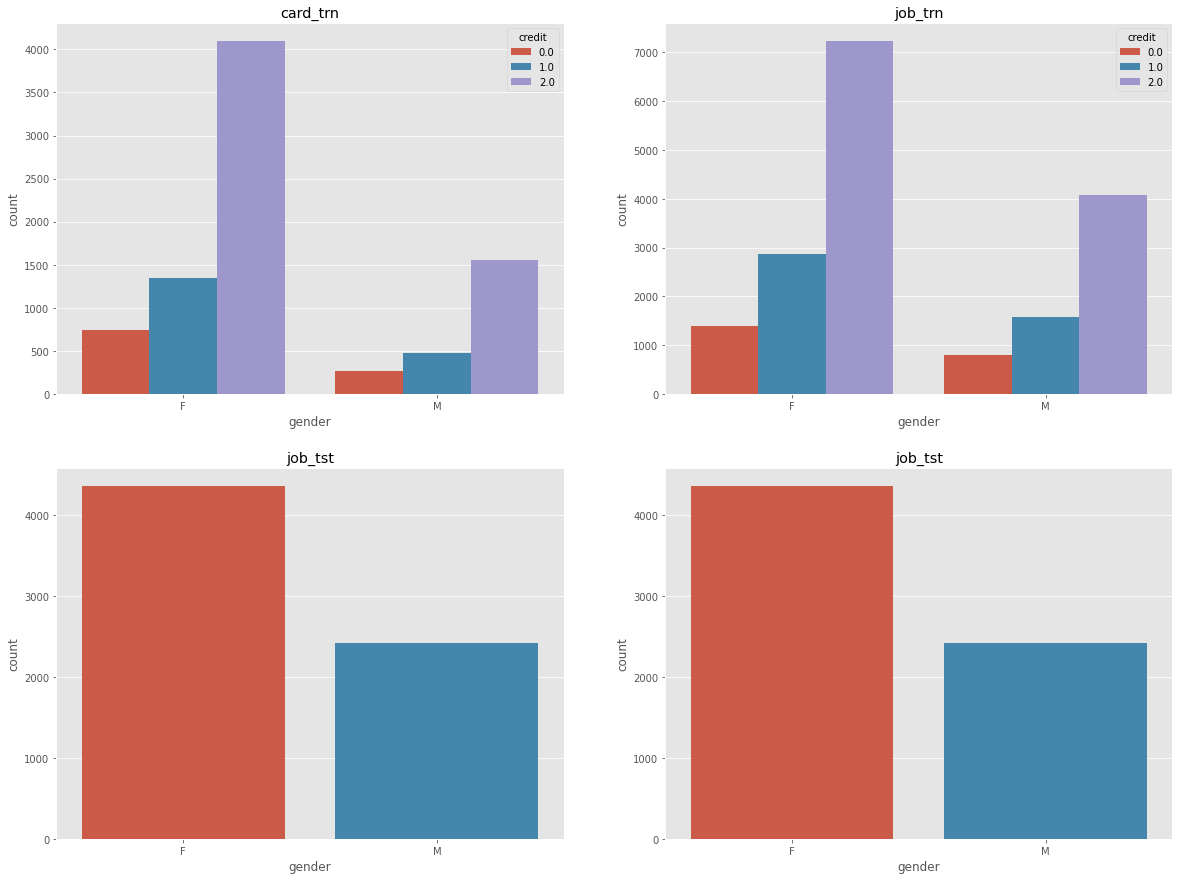

In [298]:
plt.figure(figsize = (20,15))
plt.subplot(2, 2, 1)
sns.countplot(x = 'gender',
                data = card_trn,
              hue = 'credit',
                order = card_trn['gender'].value_counts().index)
plt.title('card_trn')
plt.ylabel("count")

plt.subplot(2, 2, 2)
sns.countplot(x = 'gender',
                data = job_trn,
              hue = 'credit',
                order = job_trn['gender'].value_counts().index)
plt.title('job_trn')
plt.ylabel("count")

plt.subplot(2, 2, 3)
sns.countplot(x = 'gender',
                data = job_tst,
                order = job_tst['gender'].value_counts().index)
plt.title('job_tst')
plt.ylabel("count")

plt.subplot(2, 2, 4)
sns.countplot(x = 'gender',
                data = job_tst,
                order = job_tst['gender'].value_counts().index)
plt.title('job_tst')
plt.ylabel("count")

In [308]:
## 생활방식 counts()
print(card_trn.groupby('house_type')['credit'].count())
print()
print(card_trn.groupby('credit')['credit'].count())
print()
print(card_trn.groupby(['house_type','credit'])['credit'].count())
print()
print('####################################################')
print()
print(job_trn.groupby('house_type')['credit'].count())
print()
print(job_trn.groupby('credit')['credit'].count())
print()
print(job_trn.groupby(['house_type','credit'])['credit'].count())

house_type
Co-op apartment          44
House / apartment      7783
Municipal apartment     257
Office apartment         34
Rented apartment         91
With parents            280
Name: credit, dtype: int64

credit
0.0    1014
1.0    1821
2.0    5654
Name: credit, dtype: int64

house_type           credit
Co-op apartment      0.0          4
                     1.0         13
                     2.0         27
House / apartment    0.0        949
                     1.0       1663
                     2.0       5171
Municipal apartment  0.0         22
                     1.0         56
                     2.0        179
Office apartment     0.0          2
                     1.0          4
                     2.0         28
Rented apartment     0.0          5
                     1.0         27
                     2.0         59
With parents         0.0         32
                     1.0         58
                     2.0        190
Name: credit, dtype: int64

##################

AxesSubplot(0.125,0.125;0.775x0.755)


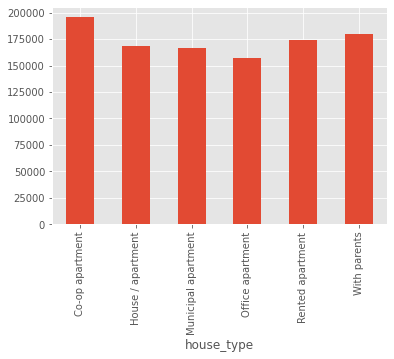


AxesSubplot(0.125,0.125;0.775x0.755)


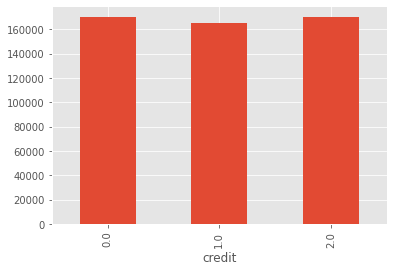


AxesSubplot(0.125,0.125;0.775x0.755)


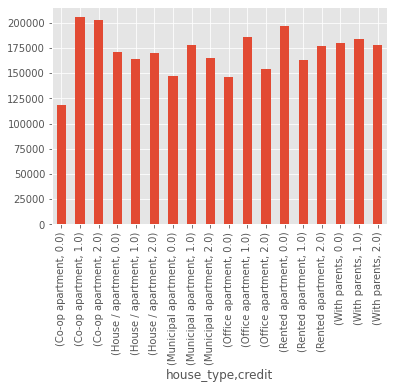


####################################################

AxesSubplot(0.125,0.125;0.775x0.755)


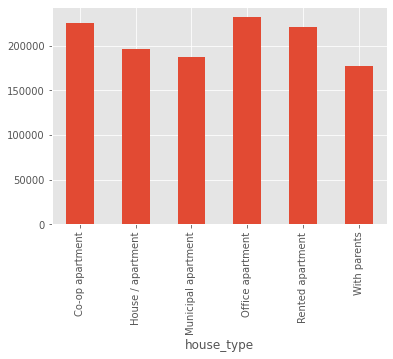


AxesSubplot(0.125,0.125;0.775x0.755)


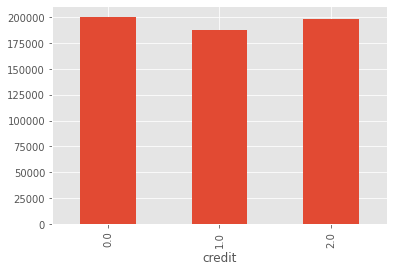


AxesSubplot(0.125,0.125;0.775x0.755)


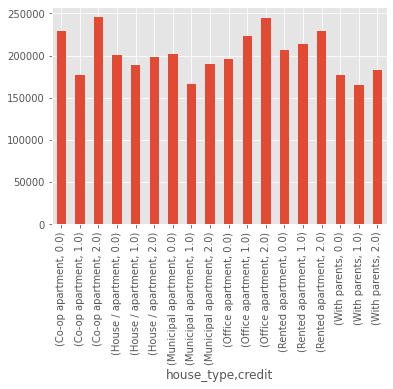

In [315]:
## 생활방식 차이
print(card_trn.groupby('house_type')['income_total'].mean().plot.bar())
plt.show()
print()
print(card_trn.groupby('credit')['income_total'].mean().plot.bar())
plt.show()
print()
print(card_trn.groupby(['house_type','credit'])['income_total'].mean().plot.bar())
plt.show()
print()
print('####################################################')
print()
print(job_trn.groupby('house_type')['income_total'].mean().plot.bar())
plt.show()
print()
print(job_trn.groupby('credit')['income_total'].mean().plot.bar())
plt.show()
print()
print(job_trn.groupby(['house_type','credit'])['income_total'].mean().plot.bar())
plt.show()

In [316]:
## 직업유형 counts()
print(card_trn.groupby('occyp_type')['credit'].count())
print()
print(card_trn.groupby('credit')['credit'].count())
print()
print(card_trn.groupby(['occyp_type','credit'])['credit'].count())
print()
print('####################################################')
print()
print(job_trn.groupby('occyp_type')['credit'].count())
print()
print(job_trn.groupby('credit')['credit'].count())
print()
print(job_trn.groupby(['occyp_type','credit'])['credit'].count())

occyp_type
Accountants              178
Cleaning staff            78
Cooking staff            103
Core staff               415
Drivers                  412
HR staff                   7
High skill tech staff    169
IT staff                  12
Laborers                 762
Low-skill Laborers        27
Managers                 320
Medicine staff            97
Private service staff     40
Realty agents              3
Sales staff              572
Secretaries               18
Security staff           119
Waiters/barmen staff      15
Name: credit, dtype: int64

credit
0.0    1014
1.0    1821
2.0    5654
Name: credit, dtype: int64

occyp_type             credit
Accountants            0.0        14
                       1.0        42
                       2.0       122
Cleaning staff         0.0         8
                       1.0        14
                       2.0        56
Cooking staff          0.0        10
                       1.0        11
                       2.0        82
Core 

AxesSubplot(0.125,0.125;0.775x0.755)


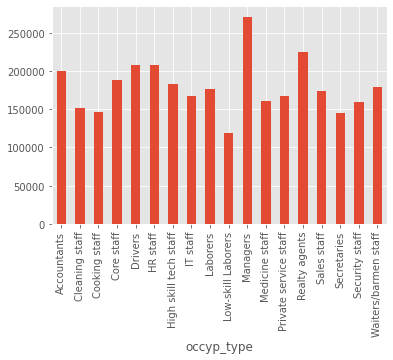


AxesSubplot(0.125,0.125;0.775x0.755)


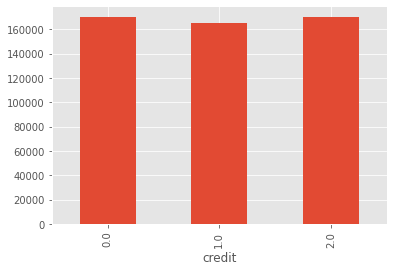


AxesSubplot(0.125,0.125;0.775x0.755)


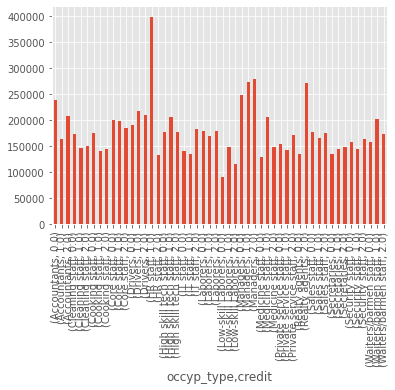


####################################################

AxesSubplot(0.125,0.125;0.775x0.755)


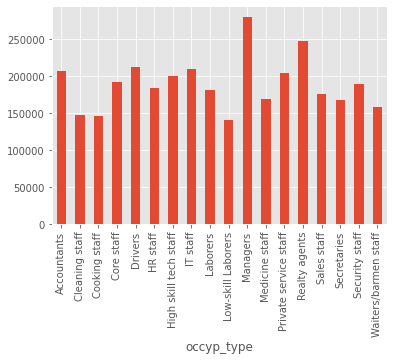


AxesSubplot(0.125,0.125;0.775x0.755)


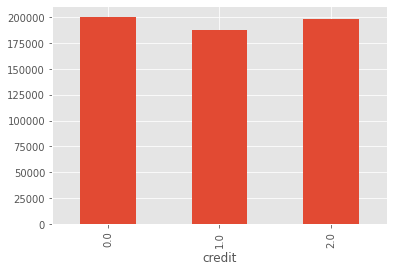


AxesSubplot(0.125,0.125;0.775x0.755)


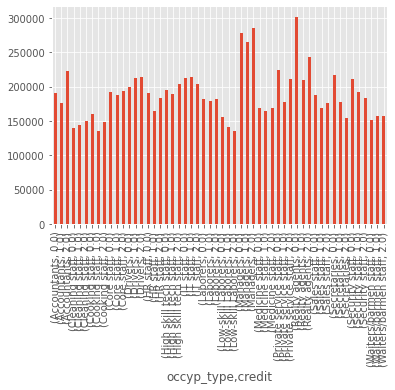

In [317]:
## 직업유형 차이
print(card_trn.groupby('occyp_type')['income_total'].mean().plot.bar())
plt.show()
print()
print(card_trn.groupby('credit')['income_total'].mean().plot.bar())
plt.show()
print()
print(card_trn.groupby(['occyp_type','credit'])['income_total'].mean().plot.bar())
plt.show()
print()
print('####################################################')
print()
print(job_trn.groupby('occyp_type')['income_total'].mean().plot.bar())
plt.show()
print()
print(job_trn.groupby('credit')['income_total'].mean().plot.bar())
plt.show()
print()
print(job_trn.groupby(['occyp_type','credit'])['income_total'].mean().plot.bar())
plt.show()

In [41]:
## 나이 변환
def days_to_age(x):
    return (x*-1)/365

## 신용카드 발급월 양수로 전환
def begin_plus_month(x):
    return (x*-1)

## 신용카드 발급월 연도로 전환
def begin_plus_year(x):
    return (x)//12

## 업무 시작일 변환
def plus(x):
    if x<0:
        return x*(-1)
    else:
        return 0

# 변수 생성

## 연속형 변수 처리

In [42]:
## 나이로 변환
trn['birth'] = days_to_age(trn.DAYS_BIRTH).round()

## 나이 구간화
trn['age'] = pd.cut(trn.birth, bins = [0,10,20,30,40,50,60,70], labels = ['10','20','30','40','50','60','70']).astype(int)
trn['age']

## 신용카드 발급월 변수의 변환
trn['begin_month_plus'] = begin_plus_month(trn.begin_month).round()

## 신용카드 발급월 연차로 변환
trn['begin_month_year'] = begin_plus_year(trn.begin_month_plus)

## 신용카드 발급월 구간화
trn['begin_month_bin'] = pd.cut(trn.begin_month_plus, bins = [-10,10,20,30,40,50,60,70], labels = ['10','20','30','40','50','60','70']).astype(int)
trn['begin_month_bin'].value_counts()

## 업무시작일 양수로 변환
trn['employed_plus'] = trn.DAYS_EMPLOYED.map(plus)
trn['employed_plus']

## 0과 1로 범주화 (업무를 하는 사람과 아닌 사람)
trn['employed_bin'] = trn.employed_plus.map(lambda x : 0 if x==0 else 1)

## 업무 연차로 변환
trn['employed_bin2'] = trn['employed_plus']//365
trn['employed_bin2']

# trn['credit'] = trn.credit.astype('object')

index
0        12
1         4
2        12
3         5
4         5
         ..
26452     5
26453     6
26454     5
26455     0
26456     2
Name: employed_bin2, Length: 26457, dtype: int64

In [43]:
## 나이로 변환
tst['birth'] = days_to_age(tst.DAYS_BIRTH).round()

## 나이 구간화
tst['age'] = pd.cut(tst.birth, bins = [0,10,20,30,40,50,60,70], labels = ['10','20','30','40','50','60','70']).astype(int)

## 신용카드 발급월 변수의 변환
tst['begin_month_plus'] = begin_plus_month(tst.begin_month).round()

## 신용카드 발급월 연차로 변환
tst['begin_month_year'] = begin_plus_year(tst.begin_month_plus)

## 신용카드 발급월 구간화
tst['begin_month_bin'] = pd.cut(tst.begin_month_plus, bins = [-10,10,20,30,40,50,60,70], labels = ['10','20','30','40','50','60','70']).astype(int)

## 업무시작일 양수로 변환
tst['employed_plus'] = tst.DAYS_EMPLOYED.map(plus)

## 0과 1로 범주화 (업무를 하는 사람과 아닌 사람)
tst['employed_bin'] = tst.employed_plus.map(lambda x : 0 if x==0 else 1)

## 업무 연차로 변환
tst['employed_bin2'] = tst['employed_plus']//365


##  범주형 변수

In [38]:
## 성별 : 여성을 0으로 남성을 1로 변환
trn['gender'] = trn['gender'].map({'F': '0', 'M': '1'})

## 자동차 소유 여부 : No 0으로 yes를 1로 변환
trn['car'] = trn['car'].map({'N': '0', 'Y': '1'})

## 부동산 소유 여부 : No 0으로 yes를 1로 변환
trn['reality'] = trn['reality'].map({'N': '0', 'Y': '1'})

# trn['edu_type'] = trn.edu_type.map({'Academic degree' : '0', 
#                   "Lower secondary" : '1', 
#                   'Incomplete higher' : '2',
#                  'Secondary / secondary special':'3',
#                  'Higher education':4})

# trn['income_type'] = trn.income_type.map({'Commercial associate' : '0', 
#                   "Working" : '1', 
#                   'State servant' : '2',
#                  'Pensioner':'3',
#                  'Student':'4'})

# trn['family_type'] = trn.family_type.map({'Married' : '0', 
#                   "Civil marriage" : '1', 
#                   'Separated' : '2',
#                  'Single / not married':'3',
#                  'Widow':'4'})

# trn['house_type'] = trn.house_type.map({'Municipal apartment' : '0', 
#                   "House / apartment" : '1', 
#                   'With parents' : '2',
#                  'Co-op apartment':'3',
#                  'Rented apartment':'4',
#                   'Office apartment' : '5'  })

In [39]:
## 성별 : 여성을 0으로 남성을 1로 변환
tst['gender'] = tst['gender'].map({'F': '0', 'M': '1'})

## 자동차 소유 여부 : No 0으로 yes를 1로 변환
tst['car'] = tst['car'].map({'N': '0', 'Y': '1'})

## 부동산 소유 여부 : No 0으로 yes를 1로 변환
tst['reality'] = tst['reality'].map({'N': '0', 'Y': '1'})

# tst['edu_type'] = tst.edu_type.map({'Academic degree' : 0, 
#                   "Lower secondary" : 1, 
#                   'Incomplete higher' : 2,
#                  'Secondary / secondary special':3,
#                  'Higher education':4})

# tst['income_type'] = tst.income_type.map({'Commercial associate' : '0', 
#                   "Working" : '1', 
#                   'State servant' : '2',
#                  'Pensioner':'3',
#                  'Student':'4'})

# tst['family_type'] = tst.family_type.map({'Married' : '0', 
#                   "Civil marriage" : '1', 
#                   'Separated' : '2',
#                  'Single / not married':'3',
#                  'Widow':'4'})

# tst['house_type'] = tst.house_type.map({'Municipal apartment' : '0', 
#                   "House / apartment" : '1', 
#                   'With parents' : '2',
#                  'Co-op apartment':'3',
#                  'Rented apartment':'4',
#                   'Office apartment' : '5'  })

## NONE 범주 사용

In [44]:
## occyp_type의 결측값들을 NONE이라는 범주로 만듦
trn['occyp_type'] = trn['occyp_type'].fillna('NONE').astype(str).values
tst['occyp_type'] = tst['occyp_type'].fillna('NONE').astype(str).values

## 라벨 인코딩 (보류)

In [46]:
trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            26457 non-null  object 
 1   car               26457 non-null  object 
 2   reality           26457 non-null  object 
 3   child_num         26457 non-null  int64  
 4   income_total      26457 non-null  float64
 5   income_type       26457 non-null  object 
 6   edu_type          26457 non-null  object 
 7   family_type       26457 non-null  object 
 8   house_type        26457 non-null  object 
 9   DAYS_BIRTH        26457 non-null  int64  
 10  DAYS_EMPLOYED     26457 non-null  int64  
 11  FLAG_MOBIL        26457 non-null  int64  
 12  work_phone        26457 non-null  int64  
 13  phone             26457 non-null  int64  
 14  email             26457 non-null  int64  
 15  occyp_type        26457 non-null  object 
 16  family_size       26457 non-null  float6

In [45]:
index_col = 'index'
target_col = 'credit'

cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]
feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

26 8 18
